In [34]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Bidirectional

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Tackle TensorFlow GPU warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Display settings
pd.set_option('display.max_columns', None)

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lowkey127","key":"8c7924da381cfc11167b0d17a42dd8ea"}'}

In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [8]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 1.13GB/s]


In [9]:
!unzip sentiment140.zip

Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [13]:
import pandas as pd
path="training.1600000.processed.noemoticon.csv"
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="latin1")
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [20]:
# Column names as the file has no headers
columns = ['target', 'id', 'date', 'query', 'user', 'text']

# Reading the CSV file
df = pd.read_csv(path, encoding='latin-1', names=columns)
df.head()

,target,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [21]:
data = df.drop(columns=["id", "user", "date", "query"], axis=1)

data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [22]:
# Function to clean the tweet text
def clean_text(text):
    # Removing URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Removing mentions
    text = re.sub(r"@\w+", "", text)

    # Removing hashtags
    text = re.sub(r"#\w+", "", text)

    # Removing special characters and digits
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Removing extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Clean the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Display the cleaned data
data[['text', 'cleaned_text']].head()


,text,cleaned_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",A thats a bummer You shoulda got David Carr of...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...


In [26]:
print(data.columns)


Index(['target', 'text', 'cleaned_text'], dtype='object')


In [28]:
df.target.value_counts()

,count
target,
0,800000
4,800000


In [29]:
# Maping the target to binary
data['target'] = data['target'].map({0: 0, 4: 1})

# Display the updated data
data[['text', 'target']].head()

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [31]:
data.sample(5)

,target,text,cleaned_text
1240644,1,"@KhloeKardashian well if you were here, you co...",well if you were here you could do my kickboxi...
10317,0,@itvhellskitchen Is that preview for UK visito...,Is that preview for UK visitors only There are...
674221,0,@soupVERSUSsushi however I'm sad that now I'm ...,however Im sad that now Im such a loser that I...
1254473,1,@StephCyrus09 Cool! i love it!,Cool i love it
1312430,1,Hooray! My PWK shares have now made more $ tha...,Hooray My PWK shares have now made more than m...


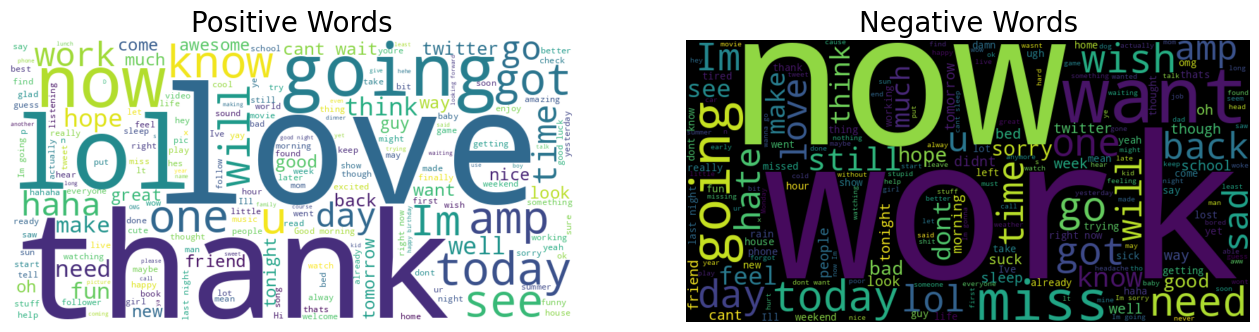

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Positive Tweets WordCloud
positive_text = ' '.join(data[data['target'] == 1]['cleaned_text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Negative Tweets WordCloud
negative_text = ' '.join(data[data['target'] == 0]['cleaned_text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

# Plotting the word clouds
plt.figure(figsize=(16,8))

# Positive WordCloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Words', fontsize=20)
plt.axis('off')

# Negative WordCloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Words', fontsize=20)
plt.axis('off')

plt.show()

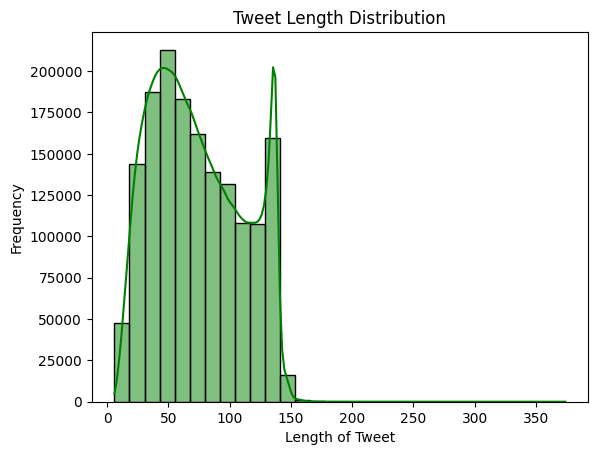

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate length of each text
data['text_length'] = data['text'].apply(len)

# Plot text length distribution
sns.histplot(data['text_length'], bins=30, kde=True, color='green')
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

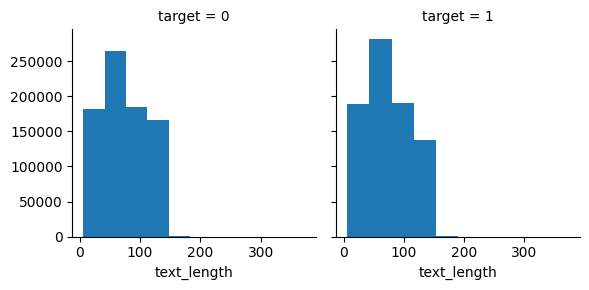

In [49]:
# Plot histogram of text lengths for each sentiment
g = sns.FacetGrid(data, col='target')
g.map(plt.hist, 'text_length')
plt.show()

In [76]:
# text cleaning
def clean_text(s):
    s = re.sub(r'@[A-Za-z0-9]+', ' ', s) # remove mentions
    s = re.sub(r'#', ' ', s)             # remove hashtags symbol
    s = re.sub(r'RT[\s]+', ' ', s)        # remove RT
    s = re.sub(r'https?:\/\/\S+', ' ', s) # remove hyperlinks
    s = re.sub('&amp', ' ', s)            # remove ampersand
    return s

# Apply the cleaning function to the correct text column
data['clean_text'] = data['text'].apply(clean_text)

# (Optional) Preview cleaned text
data[['target', 'clean_text']].head()

,target,clean_text
0,0,"- Awww, that's a bummer. You shoulda got ..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to ...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why a..."


In [77]:
# Features and labels
X = data['clean_text']
y = pd.get_dummies(data['target']).values
num_classes = data['target'].nunique()

print(X.head())
print(y[:5])
print(f"Number of Classes: {num_classes}")

0        - Awww, that's a bummer.  You shoulda got ...
1    is upset that he can't update his Facebook by ...
2      I dived many times for the ball. Managed to ...
3      my whole body feels itchy and like its on fire 
4      no, it's not behaving at all. i'm mad. why a...
Name: clean_text, dtype: object
[[ True False]
 [ True False]
 [ True False]
 [ True False]
 [ True False]]
Number of Classes: 2


Epoch 1/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 936s 47ms/step - accuracy: 0.7851 - loss: 0.4565 - val_accuracy: 0.8156 - val_loss: 0.4038
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 939s 47ms/step - accuracy: 0.8179 - loss: 0.4032 - val_accuracy: 0.8196 - val_loss: 0.3963
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 945s 47ms/step - accuracy: 0.8252 - loss: 0.3888 - val_accuracy: 0.8222 - val_loss: 0.3922
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step
Accuracy: 82.2%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82    160000
           1       0.83      0.81      0.82    160000

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



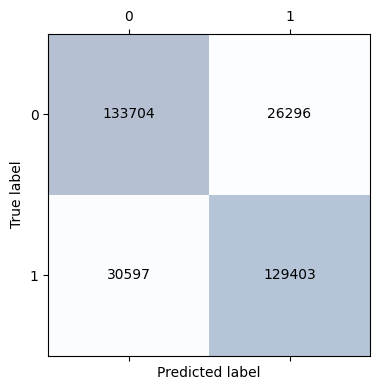

In [78]:
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Preprocess data (use a smaller subset for faster experimentation)
max_features = 5000  # Reduced for faster training
max_words = 50       # Reduced for padding
embed_dim = 100      # Standard embedding size

# Tokenization and Padding
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_words)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_words)

# Model Definition
def get_model(max_features, embed_dim):
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=max_words))  # Reduced max_words
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))  # Reduced LSTM units
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(2, activation='softmax'))  # Softmax for binary classification
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Training Function
def model_train(model, X_train, y_train, X_test, y_test):
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(X_train, y_train, batch_size=64, epochs=3, validation_data=(X_test, y_test), callbacks=[early_stopping])  # Reduced epochs

# Model Evaluation Function
def model_evaluate(model, X_test_pad, y_test):
    y_pred_test = np.argmax(model.predict(X_test_pad), axis=1)
    print(f'Accuracy: {accuracy_score(np.argmax(y_test, axis=1), y_pred_test) * 100:.1f}%')

    print('\nClassification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred_test))

    # Confusion matrix
    confmat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

# Model Training
model = get_model(max_features, embed_dim)
model_train(model, X_train_pad, y_train, X_test_pad, y_test)

# Model Evaluation
model_evaluate(model, X_test_pad, y_test)
